# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tsai optuna --quiet

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torc

In [ ]:
import optuna
import pickle
from tsai.all import *
from sklearn.preprocessing import minmax_scale
from scipy import signal
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
my_setup(optuna, sklearn)

os              : Linux-6.1.85+-x86_64-with-glibc2.35
python          : 3.11.11
tsai            : 0.3.9
fastai          : 2.7.18
fastcore        : 1.7.28
optuna          : 4.2.0
sklearn         : 1.6.0
torch           : 2.2.2+cu121
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : [15.0] GB


In [ ]:
dataset_path = "/content/drive/MyDrive/KOA-work-main/koa-work/codes/gait_cycle_train_test_dataset.pkl"
with open(dataset_path, 'rb') as f:
    [train_df, test_df] = pickle.load(f)
    [train_df, test_df] = pickle.load(f)

train_df = pd.concat([train_df, test_df])
print(train_df.shape, test_df.shape)

train_df.head(2)

joint_names = np.array(['pelv', 'lhip', 'rhip', 'spi1', 'lkne', 'rkne', 'spi2', 'lank',
       'rank', 'spi3', 'ltoe', 'rtoe', 'neck', 'lcla', 'rcla', 'head',
       'lsho', 'rsho', 'lelb', 'relb', 'lwri', 'rwri', 'lhan', 'rhan'])

joint_names_idx = [1, 2, 4, 5, 7, 8, 10, 11]
joint_names = joint_names[joint_names_idx]
joint_names

train_df['jointlocs'] = train_df['poses3d_filtered'].apply(lambda x:signal.resample(x[:,joint_names_idx,:], 101))

X = np.asarray([i for i in train_df['jointlocs'].values]).reshape(725,101, len(joint_names_idx)*3)
X = np.einsum('kli->kil', X)

y = train_df['target_class'].values

X.shape, y.shape

(725, 11) (155, 11)


((725, 24, 101), (725,))

# OPTUNA random split

In [ ]:
def get_random_splits(X_, y_, folds_, random_state_):
  skf = StratifiedKFold(n_splits=folds_, shuffle=True, random_state=random_state_)

  return list(skf.split(X_, y_))

folds = 5
random_state_fold = 42
final_splits = get_random_splits(X, y, folds, random_state_fold)

In [ ]:
def objective_random_split(trial):
  n_epoch = 50
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
  tfms  = [None, [Categorize()]]
  bs = 64
  arch = LSTM_FCN
  k = {'hidden_size':trial.suggest_int("hidden_size", 10, 100),
      'rnn_layers':trial.suggest_int("rnn_layers", 1, 3),
      'cell_dropout':trial.suggest_float('cell_dropout', 0, 1, log=False),
      'rnn_dropout':trial.suggest_float('rnn_dropout', 0, 1, log=False),
      'fc_dropout':trial.suggest_float('fc_dropout', 0, 1, log=False),
      'conv_layers':trial.suggest_categorical('conv_layers', [[8, 16, 8], [16, 32, 16], [32, 64, 32]]),}
  k['bidirectional'] = True

  split = final_splits[0]
  dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)
  results_subj = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'fold_no', 'train loss', 'valid loss', 'accuracy', 'roc_score','time',
                                  'test_acc', 'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1], 'test_f1_'+dls.vocab[2],
                                  'test_f1_'+dls.vocab[3], 'test_auc_scr',
                                  'train_splits', 'test_splits', 'prob_scores', 'predictions', 'y_test','test_f1_weighted'])

  for fold_no, split in enumerate(final_splits):
    dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)

    model = create_model(arch, dls=dls, **k)
    # print(model.__class__.__name__)

    learn = Learner(dls, model,  metrics=[accuracy, RocAuc(multi_class='ovr')])
    start = time.time()
    with learn.no_logging():
      learn.fit_one_cycle(n_epoch, learning_rate)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]

    # test set
    preds, y_test = learn.get_preds(1)
    # Convert predictions to probabilities if they are logits
    probs = preds.softmax(dim=-1)
    # Get class predictions (e.g., argmax for classification)
    predictions = preds.argmax(dim=-1)

    y_test = y_test.cpu().numpy()
    predictions = predictions.cpu().numpy()
    prob_scores = preds.cpu().numpy()

    y_binarized = label_binarize(y_test, classes=[0,1,2,3])
    test_acc = accuracy_score(y_test, predictions)
    test_f1 = f1_score(y_test, predictions, labels=[0,1,2,3], average=None)
    auc_scr = roc_auc_score(y_binarized, prob_scores, multi_class='ovr')
    test_f1_weighted = f1_score(y_test, predictions, labels=[0,1,2,3], average='weighted')

    # logging
    results_subj.loc[fold_no] = [arch.__name__, k, count_parameters(model), fold_no,
                                    vals[0], vals[1], vals[2], vals[3], int(elapsed),
                                    test_acc, test_f1[0], test_f1[1], test_f1[2], test_f1[3], auc_scr,
                                      dsets.splits[0], dsets.splits[1], prob_scores, predictions, y_test, test_f1_weighted]

  return results_subj[['test_f1_weighted','test_f1_EL','test_f1_MD','test_f1_NM','test_f1_SV']].min().min()

study_random = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())

study_random.optimize(objective_random_split, n_trials=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#save_path = '/content/drive/MyDrive/KOA-work-main/koa-work/codes/results/optuna_study_random1.pkl'
#with open(save_path, 'wb') as f:
#  pickle.dump(study_random, f)

save_path = '/content/drive/MyDrive/KOA-work-main/koa-work/codes/results/optuna_study_random1.pkl'
with open(save_path, 'rb') as f:
  study_random = pickle.load(f)

In [ ]:
study_random_df = study_random.trials_dataframe()
study_random_df.shape

(300, 13)

In [ ]:
print("Best trial:")
trial = study_random.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.8181818181818182
  Params: 
    learning_rate: 0.008514242712261609
    hidden_size: 10
    rnn_layers: 2
    cell_dropout: 0.6857840951931344
    rnn_dropout: 0.6254297787456161
    fc_dropout: 0.11570575343807674
    conv_layers: [32, 64, 32]


In [ ]:
trial = study_random.best_trial

n_epoch = 50
learning_rate = trial.params['learning_rate']
tfms  = [None, [Categorize()]]
bs = 64
arch = LSTM_FCN
k = {'hidden_size':trial.params["hidden_size"],
    'rnn_layers':trial.params["rnn_layers"],
    'cell_dropout':trial.params['cell_dropout'],
    'rnn_dropout':trial.params['rnn_dropout'],
    'bidirectional':True,
    'fc_dropout':trial.params['fc_dropout'],
    'conv_layers':trial.params['conv_layers']}

split = final_splits[0]
dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)
results_rand = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'fold_no', 'train loss', 'valid loss', 'accuracy', 'roc_score','time',
                                'test_acc', 'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1], 'test_f1_'+dls.vocab[2],
                                'test_f1_'+dls.vocab[3], 'test_auc_scr',
                                'train_splits', 'test_splits', 'prob_scores', 'predictions', 'y_test', 'test_f1_weighted'])

for fold_no, split in enumerate(final_splits):
  dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)

  model = create_model(arch, dls=dls, **k)
  # print(model.__class__.__name__)

  learn = Learner(dls, model,  metrics=[accuracy, RocAuc(multi_class='ovr')])
  start = time.time()
  with learn.no_logging():
    learn.fit_one_cycle(n_epoch, learning_rate)
  elapsed = time.time() - start
  vals = learn.recorder.values[-1]

  # test set
  preds, y_test = learn.get_preds(1)
  # Convert predictions to probabilities if they are logits
  probs = preds.softmax(dim=-1)
  # Get class predictions (e.g., argmax for classification)
  predictions = preds.argmax(dim=-1)

  y_test = y_test.cpu().numpy()
  predictions = predictions.cpu().numpy()
  prob_scores = preds.cpu().numpy()
  y_binarized = label_binarize(y_test, classes=[0,1,2,3])

  test_acc = accuracy_score(y_test, predictions)
  test_f1 = f1_score(y_test, predictions, labels=[0,1,2,3], average=None)
  auc_scr = roc_auc_score(y_binarized, prob_scores, multi_class='ovr')
  test_f1_weighted = f1_score(y_test, predictions, labels=[0,1,2,3], average='weighted')

  # logging
  results_rand.loc[fold_no] = [arch.__name__, k, count_parameters(model), fold_no,
                                  vals[0], vals[1], vals[2], vals[3], int(elapsed),
                                  test_acc, test_f1[0], test_f1[1], test_f1[2], test_f1[3], auc_scr,
                                    dsets.splits[0], dsets.splits[1], prob_scores, predictions, y_test, test_f1_weighted]

results_rand[['fold_no', 'train loss', 'valid loss', 'roc_score',
         'test_acc', 'test_f1_weighted', 'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1], 'test_f1_'+dls.vocab[2], 'test_f1_'+dls.vocab[3]]]

,fold_no,train loss,valid loss,roc_score,test_acc,test_f1_weighted,test_f1_EL,test_f1_MD,test_f1_NM,test_f1_SV
0,0,0.111445,0.245441,0.986346,0.910345,0.909548,0.833333,0.882353,0.931507,0.966292
1,1,0.092708,0.292798,0.979788,0.903448,0.901833,0.813559,0.835821,0.947368,0.977273
2,2,0.081470,0.261922,0.985482,0.896552,0.895241,0.818182,0.825397,0.929577,0.977778
3,3,0.093781,0.130283,0.996293,0.944828,0.944908,0.950820,0.882353,0.985507,0.956522
4,4,0.103508,0.270883,0.980752,0.882759,0.883020,0.806452,0.823529,0.916667,0.954545


from matplotlib import pyplot as plt
_df_0['fold_no'].plot(kind='hist', bins=20, title='fold_no')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['train loss'].plot(kind='hist', bins=20, title='train loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['valid loss'].plot(kind='hist', bins=20, title='valid loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['roc_score'].plot(kind='hist', bins=20, title='roc_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='fold_no', y='train loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='train loss', y='valid loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='valid loss', y='roc_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='roc_score', y='test_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold_no']
  ys = series['train loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('fold_no', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold_no')
_ = plt.ylabel('train loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold_no']
  ys = series['valid loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('fold_no', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold_no')
_ = plt.ylabel('valid loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold_no']
  ys = series['roc_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('fold_no', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold_no')
_ = plt.ylabel('roc_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold_no']
  ys = series['test_acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('fold_no', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold_no')
_ = plt.ylabel('test_acc')

from matplotlib import pyplot as plt
_df_12['fold_no'].plot(kind='line', figsize=(8, 4), title='fold_no')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['train loss'].plot(kind='line', figsize=(8, 4), title='train loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['valid loss'].plot(kind='line', figsize=(8, 4), title='valid loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['roc_score'].plot(kind='line', figsize=(8, 4), title='roc_score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
pd.DataFrame({'mean':results_rand[['roc_score','test_acc', 'test_f1_weighted',
              'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1],
              'test_f1_'+dls.vocab[2], 'test_f1_'+dls.vocab[3]]].mean(axis=0).round(3),
             'std':results_rand[['roc_score','test_acc', 'test_f1_weighted',
              'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1],
              'test_f1_'+dls.vocab[2], 'test_f1_'+dls.vocab[3]]].std(axis=0).round(3)})

,mean,std
roc_score,0.986,0.007
test_acc,0.908,0.023
test_f1_weighted,0.907,0.023
test_f1_EL,0.844,0.060
test_f1_MD,0.850,0.030
test_f1_NM,0.942,0.027
test_f1_SV,0.966,0.011


In [ ]:
predictions_list = sum([list(i) for i in results_rand['predictions'].to_list()], [])
predictions_list = learn.dls.vocab.map_ids(predictions_list)

y_test_list = sum([list(i) for i in results_rand['y_test'].to_list()], [])
y_test_list = learn.dls.vocab.map_ids(y_test_list)

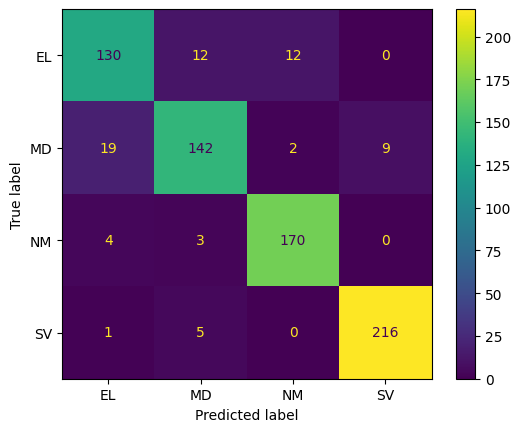

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_list,
                      predictions_list,
                      labels=learn.dls.vocab)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=learn.dls.vocab)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_list, predictions_list, labels=learn.dls.vocab))

              precision    recall  f1-score   support

          EL       0.84      0.84      0.84       154
          MD       0.88      0.83      0.85       172
          NM       0.92      0.96      0.94       177
          SV       0.96      0.97      0.97       222

    accuracy                           0.91       725
   macro avg       0.90      0.90      0.90       725
weighted avg       0.91      0.91      0.91       725



# OPTUNA Subj Based

In [ ]:
def get_subject_based_splits(train_df_, folds_, random_state_):
  skf = StratifiedKFold(n_splits=folds_, shuffle=True, random_state=random_state_)

  fold_splits = []
  for t in train_df_['target_class'].unique():
    unique_subjs = train_df_[train_df_['target_class']==t]['subject_id'].unique()
    # print(t, len(unique_subjs))

    target_splits = []
    for fold_no, split in enumerate(skf.split(unique_subjs, np.array(len(unique_subjs)*[t]))):
      train_fold_idx = train_df_[(train_df_['target_class']==t)&(train_df_['subject_id'].isin(unique_subjs[split[0]]))].index.to_numpy()
      test_fold_idx = train_df_[(train_df_['target_class']==t)&(train_df_['subject_id'].isin(unique_subjs[split[1]]))].index.to_numpy()
      # print(len(train_fold_idx), len(test_fold_idx))

      target_splits.append([train_fold_idx, test_fold_idx])
    fold_splits.append(target_splits)

  final_splits = []
  for f in range(folds):
    fold_train = []
    [fold_train.extend(s[f][0]) for s in fold_splits]
    fold_test = []
    [fold_test.extend(s[f][1]) for s in fold_splits]
    # print(f, len(fold_train), len(fold_test), len(fold_train)+len(fold_test))
    final_splits.append([fold_train, fold_test])

  return final_splits

folds = 5
random_state_fold = 42
final_splits = get_subject_based_splits(train_df.reset_index(), folds, random_state_fold)

In [ ]:
def objective_subj_based(trial):

  n_epoch = 50
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
  tfms  = [None, [Categorize()]]
  bs = 64
  arch = LSTM_FCN
  k = {'hidden_size':trial.suggest_int("hidden_size", 10, 100),
      'rnn_layers':trial.suggest_int("rnn_layers", 1, 3),
      'cell_dropout':trial.suggest_float('cell_dropout', 0, 1, log=False),
      'rnn_dropout':trial.suggest_float('rnn_dropout', 0, 1, log=False),
      'fc_dropout':trial.suggest_float('fc_dropout', 0, 1, log=False),
      'conv_layers':trial.suggest_categorical('conv_layers', [[8, 16, 8], [16, 32, 16], [32, 64, 32]]),}
  k['bidirectional'] = True

  split = final_splits[0]
  dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)
  results_subj = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'fold_no', 'train loss', 'valid loss', 'accuracy', 'roc_score','time',
                                  'test_acc', 'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1], 'test_f1_'+dls.vocab[2],
                                  'test_f1_'+dls.vocab[3], 'test_auc_scr',
                                  'train_splits', 'test_splits', 'prob_scores', 'predictions', 'y_test','test_f1_weighted'])

  for fold_no, split in enumerate(final_splits):
    dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)

    model = create_model(arch, dls=dls, **k)
    # print(model.__class__.__name__)

    learn = Learner(dls, model,  metrics=[accuracy, RocAuc(multi_class='ovr')])
    start = time.time()
    with learn.no_logging():
      learn.fit_one_cycle(n_epoch, learning_rate)
    # learn.fit_one_cycle(50, 1e-3,
    #                    cbs=EarlyStoppingCallback(monitor='valid_loss', patience=10, min_delta=0.01))
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]

    # validation set
    preds, y_test = learn.get_preds(1)
    # Convert predictions to probabilities if they are logits
    probs = preds.softmax(dim=-1)
    # Get class predictions (e.g., argmax for classification)
    predictions = preds.argmax(dim=-1)

    y_test = y_test.cpu().numpy()
    predictions = predictions.cpu().numpy()
    prob_scores = preds.cpu().numpy()

    y_binarized = label_binarize(y_test, classes=[0,1,2,3])
    test_acc = accuracy_score(y_test, predictions)
    test_f1 = f1_score(y_test, predictions, labels=[0,1,2,3], average=None)
    auc_scr = roc_auc_score(y_binarized, prob_scores, multi_class='ovr')
    test_f1_weighted = f1_score(y_test, predictions, labels=[0,1,2,3], average='weighted')

    # logging
    results_subj.loc[fold_no] = [arch.__name__, k, count_parameters(model), fold_no,
                                    vals[0], vals[1], vals[2], vals[3], int(elapsed),
                                    test_acc, test_f1[0], test_f1[1], test_f1[2], test_f1[3], auc_scr,
                                      dsets.splits[0], dsets.splits[1], prob_scores, predictions, y_test, test_f1_weighted]

  return results_subj[['test_f1_weighted','test_f1_EL','test_f1_MD','test_f1_NM','test_f1_SV']].min().min()

study_subj = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())

study_subj.optimize(objective_subj_based, n_trials=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#save_path = '/content/drive/MyDrive/KOA-work-main/koa-work/codes/results/optuna_study_subj1.pkl'
#with open(save_path, 'wb') as f:
#  pickle.dump(study_subj, f)

save_path = '/content/drive/MyDrive/KOA-work-main/koa-work/codes/results/optuna_study_subj1.pkl'
with open(save_path, 'rb') as f:
  study_subj = pickle.load(f)

In [ ]:
study_subj_df = study_subj.trials_dataframe()
study_subj_df.shape

(300, 13)

In [ ]:
print("Best trial:")
trial = study_subj.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.5490196078431373
  Params: 
    learning_rate: 0.0032400381886360584
    hidden_size: 63
    rnn_layers: 3
    cell_dropout: 0.7140075209647035
    rnn_dropout: 0.5368832616890482
    fc_dropout: 0.05819317247084359
    conv_layers: [32, 64, 32]


In [ ]:
#display(optuna.visualization.plot_optimization_history(study_subj))
#display(optuna.visualization.plot_param_importances(study_subj))
#display(optuna.visualization.plot_slice(study_subj))
#display(optuna.visualization.plot_parallel_coordinate(study_subj))

In [ ]:
trial = study_subj.best_trial

n_epoch = 50
learning_rate = trial.params['learning_rate']
tfms  = [None, [Categorize()]]
bs = 64
arch = LSTM_FCN
k = {'hidden_size':trial.params["hidden_size"],
    'rnn_layers':trial.params["rnn_layers"],
    'cell_dropout':trial.params['cell_dropout'],
    'rnn_dropout':trial.params['rnn_dropout'],
    'bidirectional':True,
    'fc_dropout':trial.params['fc_dropout'],
    'conv_layers':trial.params['conv_layers']}

split = final_splits[0]
dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)
results_subj = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'fold_no', 'train loss', 'valid loss', 'accuracy', 'roc_score','time',
                                'test_acc', 'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1], 'test_f1_'+dls.vocab[2],
                                'test_f1_'+dls.vocab[3], 'test_auc_scr',
                                'train_splits', 'test_splits', 'prob_scores', 'predictions', 'y_test', 'test_f1_weighted'])

for fold_no, split in enumerate(final_splits):
  dsets   = TSDatasets(X, y, tfms=tfms, splits=split)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=0)

  model = create_model(arch, dls=dls, **k)
  # print(model.__class__.__name__)

  learn = Learner(dls, model,  metrics=[accuracy, RocAuc(multi_class='ovr')])
  start = time.time()
  with learn.no_logging():
    learn.fit_one_cycle(n_epoch, learning_rate)
  elapsed = time.time() - start
  vals = learn.recorder.values[-1]

  # test set

  preds, y_test = learn.get_preds(1)
  # Convert predictions to probabilities if they are logits
  probs = preds.softmax(dim=-1)
  # Get class predictions (e.g., argmax for classification)
  predictions = preds.argmax(dim=-1)

  y_test = y_test.cpu().numpy()
  predictions = predictions.cpu().numpy()
  prob_scores = preds.cpu().numpy()


  y_binarized = label_binarize(y_test, classes=[0,1,2,3])
  test_acc = accuracy_score(y_test, predictions)
  test_f1 = f1_score(y_test, predictions, labels=[0,1,2,3], average=None)
  auc_scr = roc_auc_score(y_binarized, prob_scores, multi_class='ovr')
  test_f1_weighted = f1_score(y_test, predictions, labels=[0,1,2,3], average='weighted')

  # logging
  results_subj.loc[fold_no] = [arch.__name__, k, count_parameters(model), fold_no,
                                  vals[0], vals[1], vals[2], vals[3], int(elapsed),
                                  test_acc, test_f1[0], test_f1[1], test_f1[2], test_f1[3], auc_scr,
                                    dsets.splits[0], dsets.splits[1], prob_scores, predictions, y_test, test_f1_weighted]

results_subj[['fold_no', 'train loss', 'valid loss', 'roc_score',
         'test_acc', 'test_f1_weighted', 'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1], 'test_f1_'+dls.vocab[2], 'test_f1_'+dls.vocab[3]]]

,fold_no,train loss,valid loss,roc_score,test_acc,test_f1_weighted,test_f1_EL,test_f1_MD,test_f1_NM,test_f1_SV
0,0,0.172973,0.376731,0.970575,0.853659,0.855704,0.760563,0.821918,0.843373,0.950495
1,1,0.104043,0.798817,0.898677,0.698529,0.698973,0.549020,0.611111,0.767123,0.815789
2,2,0.112826,0.621135,0.934721,0.734266,0.740017,0.575758,0.681319,0.894737,0.792453
3,3,0.099030,0.649814,0.925308,0.761194,0.753054,0.576923,0.526316,0.911765,0.901099
4,4,0.102620,0.535864,0.933942,0.763514,0.773633,0.633333,0.527778,0.949153,0.895238


In [ ]:
pd.DataFrame({'mean':results_subj[['roc_score','test_acc', 'test_f1_weighted',
              'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1],
              'test_f1_'+dls.vocab[2], 'test_f1_'+dls.vocab[3]]].mean(axis=0).round(3),
             'std':results_subj[['roc_score','test_acc', 'test_f1_weighted',
              'test_f1_'+dls.vocab[0], 'test_f1_'+dls.vocab[1],
              'test_f1_'+dls.vocab[2], 'test_f1_'+dls.vocab[3]]].std(axis=0).round(3)})

,mean,std
roc_score,0.933,0.026
test_acc,0.762,0.057
test_f1_weighted,0.764,0.058
test_f1_EL,0.619,0.085
test_f1_MD,0.634,0.123
test_f1_NM,0.873,0.070
test_f1_SV,0.871,0.065


In [ ]:
predictions_list = sum([list(i) for i in results_subj['predictions'].to_list()], [])
predictions_list = learn.dls.vocab.map_ids(predictions_list)

y_test_list = sum([list(i) for i in results_subj['y_test'].to_list()], [])
y_test_list = learn.dls.vocab.map_ids(y_test_list)

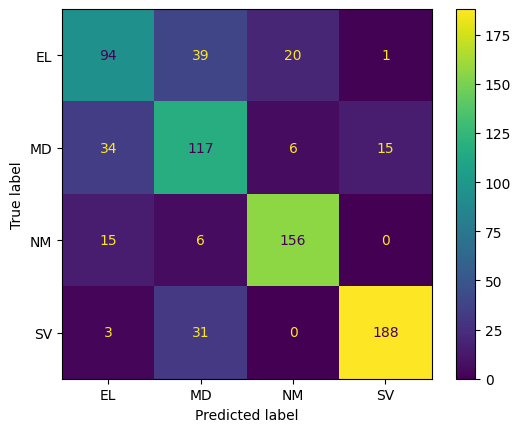

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_list,
                      predictions_list,
                      labels=learn.dls.vocab)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=learn.dls.vocab)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_list, predictions_list, labels=learn.dls.vocab))

              precision    recall  f1-score   support

          EL       0.64      0.61      0.63       154
          MD       0.61      0.68      0.64       172
          NM       0.86      0.88      0.87       177
          SV       0.92      0.85      0.88       222

    accuracy                           0.77       725
   macro avg       0.76      0.75      0.75       725
weighted avg       0.77      0.77      0.77       725



In [ ]:
#save_path = '/content/drive/MyDrive/KOA-work-main/koa-work/codes/results/optuna_bests.pkl'
#with open(save_path, 'wb') as f:
#  pickle.dump([results_rand, results_subj], f)